## Using a Gaussian Mixture Clustering Algorithm to Inspect Galaxies from JWST

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from astropy.io import fits
import glob
import time

import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D                          # custom legend
from PIL import Image                                        # making image scatter plot
from IPython.display import display                          # ''
from matplotlib.offsetbox import OffsetImage, AnnotationBbox # ''
from matplotlib.cbook import get_sample_data                 # ''
from astropy.table import vstack, Table

from sklearn.manifold import TSNE
from sklearn import manifold, datasets
from sklearn.mixture import GaussianMixture

plt.rcParams['text.usetex']= True
plt.rcParams['mathtext.fontset']= 'custom'
plt.rcParams['mathtext.default']= 'rm'
plt.rcParams['axes.formatter.use_mathtext']=False

import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Inspecting fits files

In [2]:
# example table
T = Table.read('../ngdeep_fits/ngdeep_stamps_z4_v0.1.fits')
T

ID,RA,DEC,F606W,F775W,F814W,F850L,F115W,F150W,F200W,F277W,F356W,F444W
int32[399],float64[399],float64[399],"float64[399,51,51]","float64[399,51,51]","float64[399,51,51]","float64[399,51,51]","float64[399,51,51]","float64[399,51,51]","float64[399,51,51]","float64[399,51,51]","float64[399,51,51]","float64[399,51,51]"
88 .. 22924,53.25521578436261 .. 53.231841095219245,-27.882261888601327 .. -27.8214512190614,-0.0012591968988999724 .. -0.0003202847146894783,-0.00014219828881323338 .. 0.0006081364117562771,0.0002482908603269607 .. 0.00043257742072455585,2.2495460143545642e-05 .. 0.0007356521091423929,0.0003134035977975235 .. 0.0027598734669593856,-0.0017895271084199592 .. -0.0005115613364227542,-0.00026798015147588497 .. 0.0008478333521366266,-0.0011078334771377437 .. 3.1229812495755106e-05,0.0005085881287460554 .. -0.0012236432685589125,0.0012963382927262564 .. -7.412552269730197e-05


In [3]:
len(T['ID'][0])

399

### Gathering data

In [4]:
redshift = ['z3','z4','z5','z6','z7','z8','z9','z11','z14','z17']
filters = ['F115W','F150W','F200W','F277W','F356W','F444W']
IDs = []
data = []

# for each redshift
for i in redshift: 
    T = Table.read('../ngdeep_fits/ngdeep_stamps_'f'{i}_v0.1.fits')
    
    # for each source in current redshift
    for j in range(len(T['ID'][0])): 
        IDs.append(T['ID'][0][j])
        
        # loop through desired filters
        temp_data = []
        for k in filters: 
            temp_data.append(T[f'{k}'][0][j])
        
        # add filters as a single list (1 list per source)
        data.append(temp_data)

In [5]:
# information for each source
data = np.array(data)
print(len(data[0]),'filters for each source')

6 filters for each source


In [6]:
# num of sources in dataset
len(IDs)

2310

### Gathering labels (real: 1, spurious: 0)

In [7]:
# inspected file
txt_IDs = np.loadtxt("../ngdeep_images_inspected.txt")[:, 0]    # 1st col
txt_labels = np.loadtxt("../ngdeep_images_inspected.txt")[:, 1] # 2nd col

# sort labels to be in the same order as local files
labels = []
for i in IDs:
    index = list(txt_IDs).index(i)
    labels.append(txt_labels[index])

In [8]:
print(labels.count(0),'spurious sources')

167 spurious sources


### Preprocessing image data

In [9]:
# normalize: divide by the max value in array
m = np.amax(data)
data = data / m
np.amax(data)

1.0

In [10]:
# flattening images for t-SNE readability
flattenend_images = np.array([i.flatten() for i in data])
del data
X = flattenend_images

### t-SNE dimensionality reduction of photometric images

In [11]:
tsne = TSNE(n_components=2,verbose=1,random_state=12,
            perplexity=50,n_iter=1500,metric='euclidean')

print('...begin TSNE fit_transform...\n')
time_start = time.time()
X_tsne = tsne.fit_transform(X)
print('\nTime elapsed: {} seconds'.format(round((time.time() - time_start),2)))

...begin TSNE fit_transform...

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2310 samples in 0.079s...
[t-SNE] Computed neighbors for 2310 samples in 5.014s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2310
[t-SNE] Computed conditional probabilities for sample 2000 / 2310
[t-SNE] Computed conditional probabilities for sample 2310 / 2310
[t-SNE] Mean sigma: 0.001234
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.373016
[t-SNE] KL divergence after 1500 iterations: 1.801313

Time elapsed: 51.74 seconds


### Creating DataFrame

In [12]:
T = Table()
T['source_id'] = IDs
T['label'] = labels
T['tsne_X'] = X_tsne[:,0]
T['tsne_y'] = X_tsne[:,1]

df = pd.DataFrame(np.array(T))
print(df[0:5])

   source_id  label     tsne_X     tsne_y
0         98    1.0  -6.337540  -9.346457
1        107    1.0 -10.084199 -17.356976
2        109    1.0 -16.082157 -17.683861
3        116    1.0 -10.015083 -12.344642
4        162    1.0  -2.893292  -4.473527


### t-SNE plot highlighting spurious sources

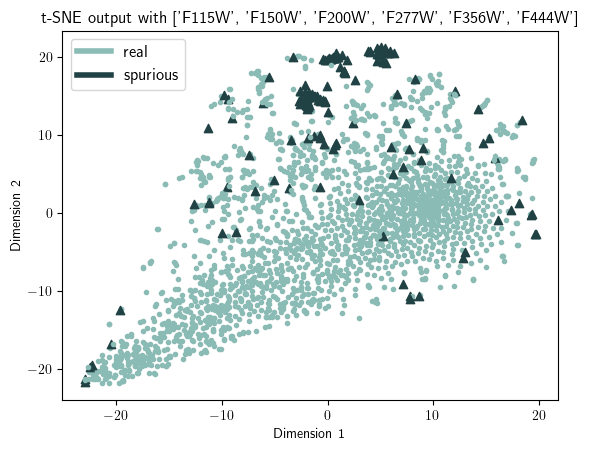

In [13]:
for i in range(len(T['source_id'])):
    if labels[i] == 0:
        plt.scatter(df['tsne_X'][i],df['tsne_y'][i],color='#214245',marker='^')
    else:
        plt.scatter(df['tsne_X'][i],df['tsne_y'][i],color='#8BBBB5',marker='.')

custom_lines = [Line2D([0], [0], color='#8BBBB5', lw=4),
                Line2D([0], [0], color='#214245', lw=4)]
plt.legend(custom_lines, ['real', 'spurious'],fontsize='large',loc='upper left')        
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE output with 'f'{filters}')
plt.show()

### t-SNE plot of images

In [14]:
relative_directory = '../ngdeep_images'
image_filenames = glob.glob(f'{relative_directory}/*.png')

In [15]:
image_IDs = []
for i in image_filenames:
    index1 = (i.index('z')) + 3
    if i[index1] == '_':        # if file is z > 9
        index1 += 1
    i = i[index1:]              # getting rid of directory string & z number
    index2 = (i.index('.'))
    ID = i[:index2]
    image_IDs.append(ID)
    
sorted_filenames = []
for i in IDs:
    index = image_IDs.index(str(i))
    sorted_filenames.append(image_filenames[index])

In [16]:
# add to dataframe
T['image_filename'] = sorted_filenames
df = pd.DataFrame(np.array(T))
print(df[0:5])

   source_id  label     tsne_X     tsne_y                      image_filename
0         98    1.0  -6.337540  -9.346457   ../ngdeep_images\ngdeep_z3_98.png
1        107    1.0 -10.084199 -17.356976  ../ngdeep_images\ngdeep_z3_107.png
2        109    1.0 -16.082157 -17.683861  ../ngdeep_images\ngdeep_z3_109.png
3        116    1.0 -10.015083 -12.344642  ../ngdeep_images\ngdeep_z3_116.png
4        162    1.0  -2.893292  -4.473527  ../ngdeep_images\ngdeep_z3_162.png


In [17]:
def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        # "resampling" term just increases resolution of image
        image.thumbnail((250, 100), Image.Resampling.LANCZOS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(15, 15, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    # Background color
    #axis.set_facecolor('grey')

Text(0, 0.5, 'Dimension 2')

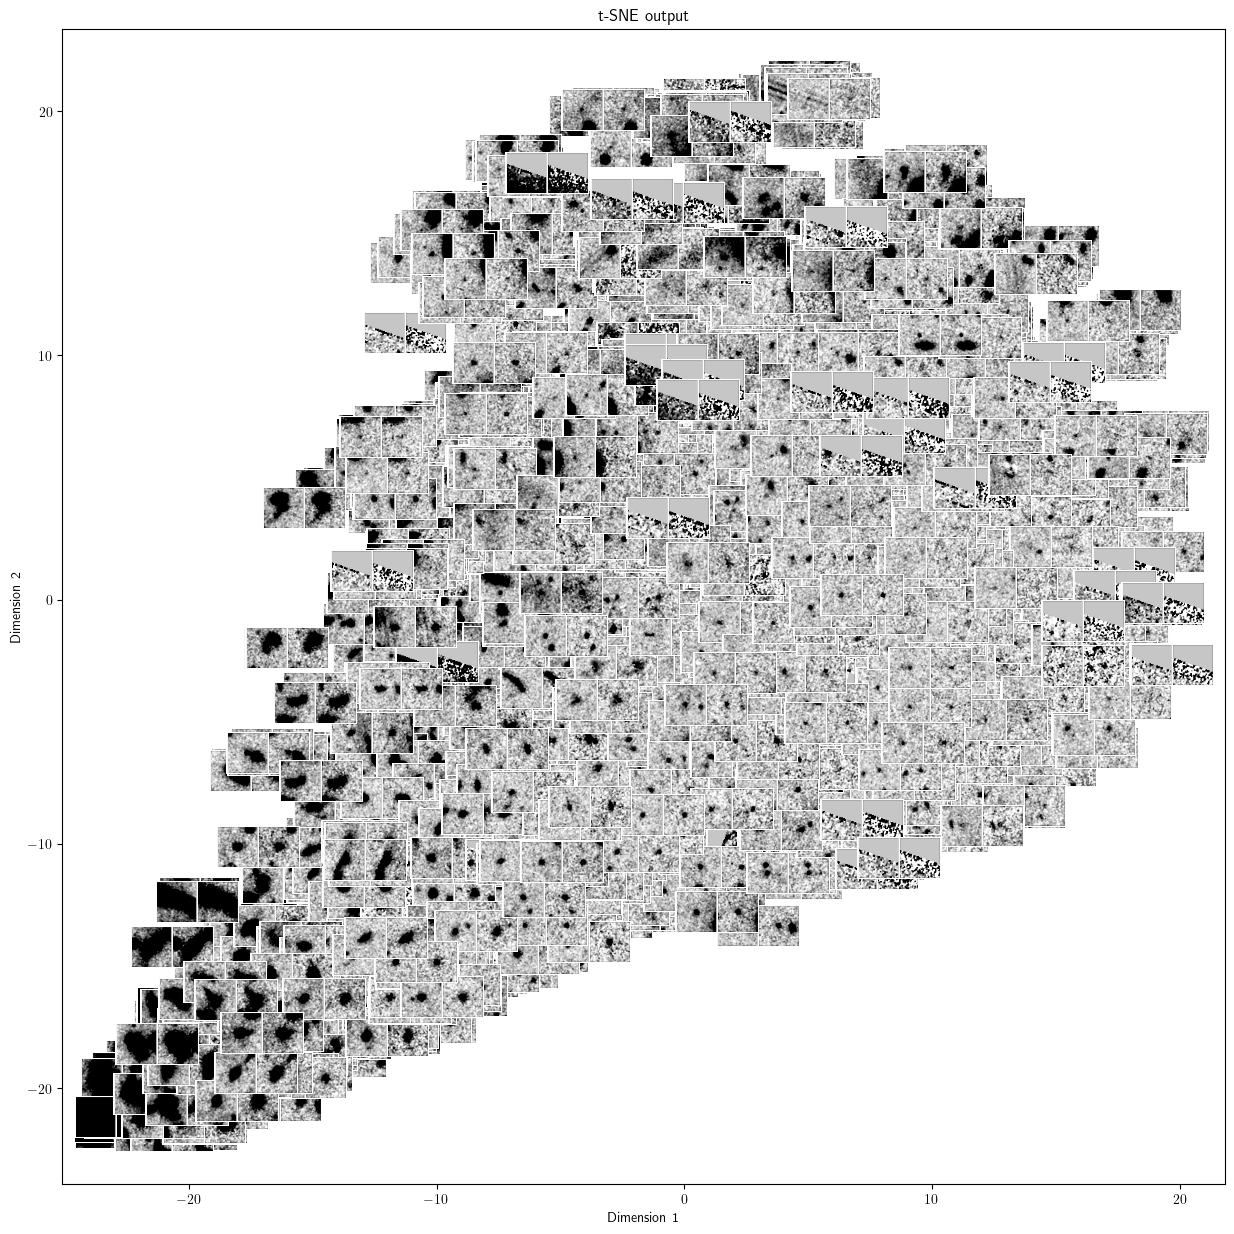

In [18]:
show_tsne(df['tsne_X'],df['tsne_y'],df['image_filename'])
plt.title('t-SNE output')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
#plt.savefig('t-SNE_image_plot_500.png',dpi=500)

### Gaussian Mixture Clustering Algorithm
* **note that for our case, 3 clusters seems reasonable**
  * **blue cluster: majority of real sources**
  * **green cluster: a sample space with a large population of spurious sources**
  * **orange cluster: a sample space with a smaller population of spurious sources**

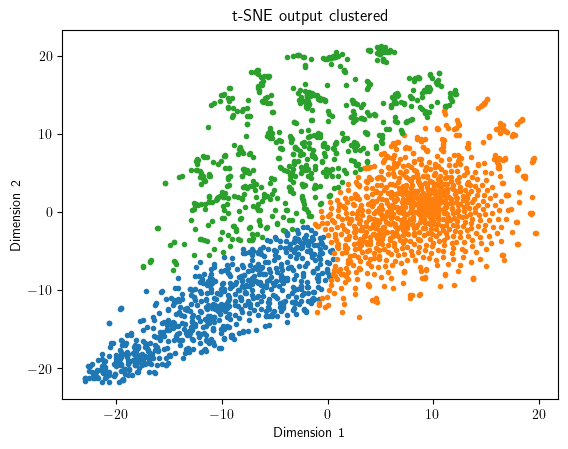

In [24]:
cluster_list = []

def plot_clusters(N): 
    model = GaussianMixture(n_components=N,random_state=12)
    model.fit(X_tsne)
    preds = model.predict(X_tsne)
    clusters = np.unique(preds)
    plt.title('t-SNE output clustered')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    for i in range(N):
        
        # indexes of sources for current cluster
        row = np.where(preds == clusters[i])
        l = 'cluster ' + str(i+1)
        
        # append sources for current cluster
        cluster_list.append(row)
        plt.scatter(X_tsne[row,0],X_tsne[row,1],label=l,marker='.')

# adjust to desired num of clusters when calling function
plot_clusters(3)